In [1]:
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import argparse
import pickle
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.style.use('ggplot')
plt.figure(figsize=(12,8), dpi= 100)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

<Figure size 1200x800 with 0 Axes>

## Preprocessing
### Lending Data

In [2]:
data_dir = "../data/lending_data/"
datasets = [str(f) for f in listdir(data_dir) if isfile(join(data_dir, f))]
money_market_dfs = {dataset[:-4] : pd.read_csv(data_dir+dataset, index_col=0)  for dataset in datasets}    

def impute_data(df, start):
    """
    impute the data for the dates between start and the beginning
    of the dataset using the head rows of the dataset
    """
    start_date = datetime.strptime(start,"%Y-%m-%d").date()
    df_start_date = df.index[0]
    ndays = (df_start_date - start_date).days
    assert ndays <= len(df), ndays
    df2 = df[:ndays].copy()
    df2.index = [start_date+timedelta(i) for i in range(ndays)]
    return df2.append(df)
        


def merge_dfs(dfs, return_col): 
    """
    merge return cols of dfs based on index column. take rolling
    mean of 7 days and return the resulting df
    """
    merged_df = None
    for name, df in dfs.items():
        df = df.rename(columns={f"{return_col}": name})[[name]]
        merged_df = (
            df if merged_df is None
            else pd.merge(merged_df, df, left_index=True, right_index=True, how="inner")
        )
    merged_df = merged_df.rolling(7, min_periods=1).mean()
    return merged_df

for market, df in money_market_dfs.items():
    x_values = [datetime.strptime(d,"%Y-%m-%d").date() for d in df.index]
    df.index = x_values
    # reverse the dataframe so that most recent data is at the tail
    money_market_dfs[market] = df.iloc[::-1]
    print(market, min(x_values))

print("\n==compound==")
money_market_dfs["compound"].head()

aave 2021-02-15
compound 2019-07-17
c_r_e_a_m_-finance 2020-08-25
definer 2020-11-03
dydx 2019-05-09
maker 2017-12-27

==compound==


,lend_rate,borrow_rate
2019-07-17,9.953725,13.775127
2019-07-18,11.207770,14.420475
2019-07-19,11.045261,14.384209
2019-07-20,13.987419,17.229919
2019-07-21,12.805582,16.663595


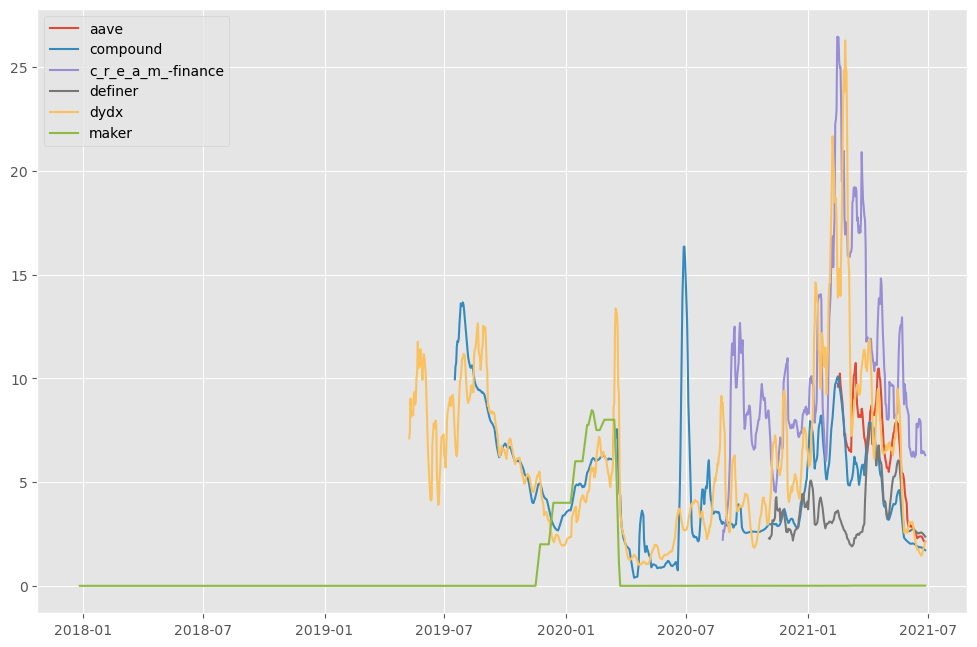

In [3]:
for k, df in money_market_dfs.items():
    x_values = df.index
    y_values = df["lend_rate"].rolling(7, min_periods=1).mean()
    plt.plot(x_values, y_values, '-', label=k)
plt.legend()
plt.show()

In [4]:
# impute 2 months of data to aave
money_market_dfs["aave"] = impute_data(money_market_dfs["aave"], '2020-12-15')

In [5]:
lend_rates_df = merge_dfs(money_market_dfs, "lend_rate")
lend_rates_df.head(10)

,aave,compound,c_r_e_a_m_-finance,definer,dydx,maker
2020-12-15,9.605199,2.795869,7.906763,2.142190,3.076519,0.0
2020-12-16,9.787979,2.866980,7.001469,2.166378,3.354302,0.0
2020-12-17,9.621263,2.924918,6.419561,2.713144,3.778307,0.0
2020-12-18,10.231641,3.170589,6.824702,3.569389,4.118970,0.0
2020-12-19,9.700448,3.351137,7.029566,3.818609,4.463759,0.0
2020-12-20,9.402057,3.434756,7.276656,3.962820,4.846873,0.0
2020-12-21,9.099764,3.607660,7.392034,4.004080,5.192434,0.0
2020-12-22,8.790926,3.806863,7.360477,4.088611,5.630153,0.0
2020-12-23,8.251581,4.019687,7.854822,4.418935,6.485842,0.0
2020-12-24,7.826617,4.222755,8.257297,4.254380,6.684585,0.0


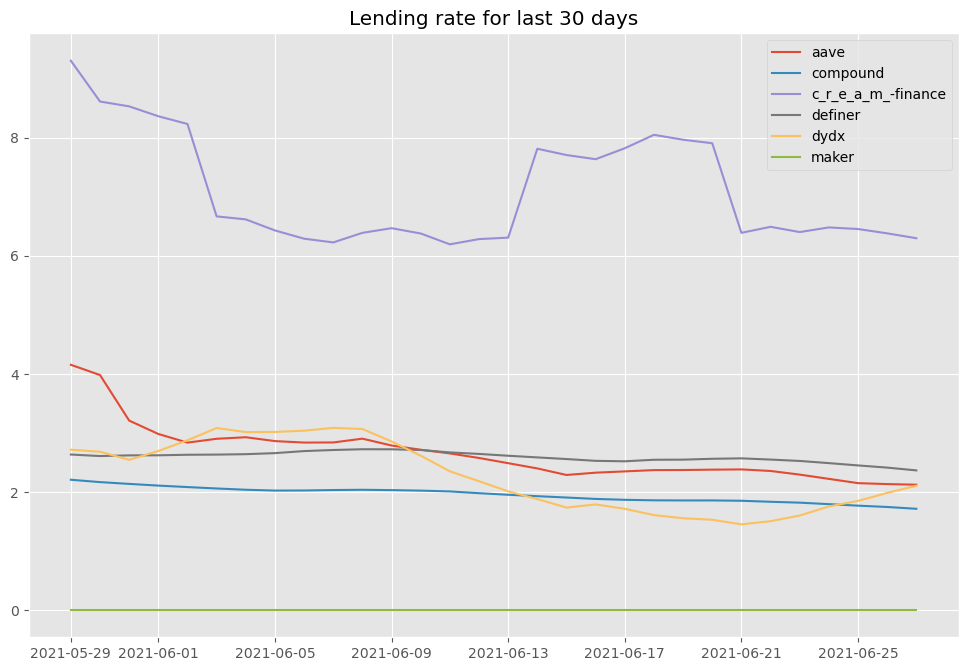

In [6]:
temp_df = lend_rates_df.tail(30)
for col in temp_df.columns:
    y_values = temp_df[col]    
    plt.plot(temp_df.index, y_values, '-', label=col)
plt.legend()
plt.title("Lending rate for last 30 days")
plt.show()

lending rates: 7 days rolling avg


<AxesSubplot:>

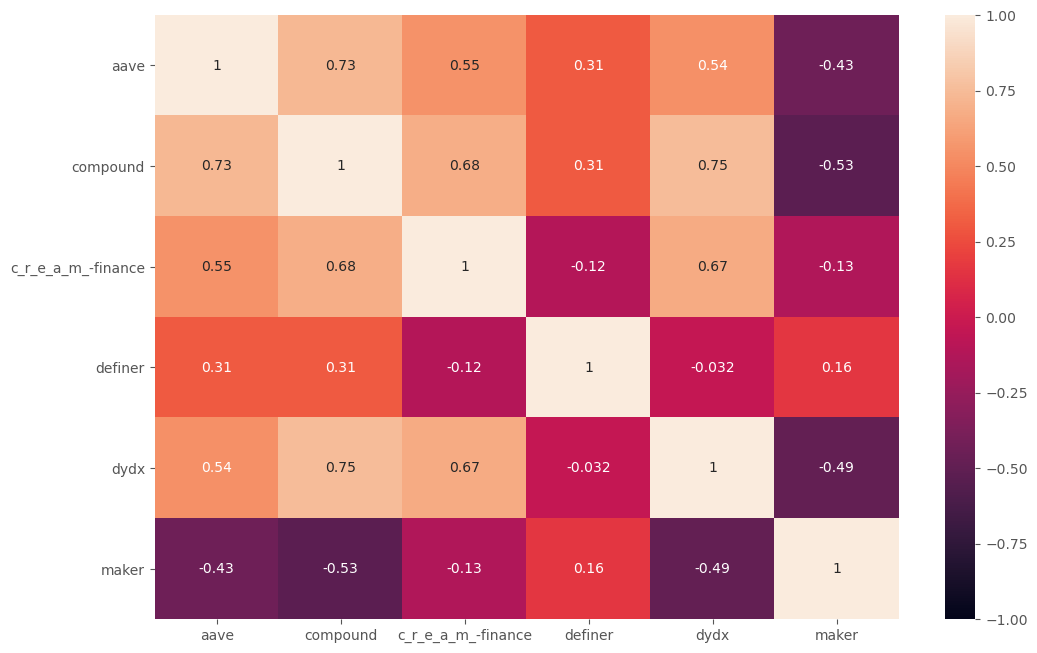

In [7]:
print("lending rates: 7 days rolling avg")
sns.heatmap(lend_rates_df.corr(), vmin=-1, vmax=1, annot=True)

lending rates: 7 days rolling avg for last 30 days


<AxesSubplot:>

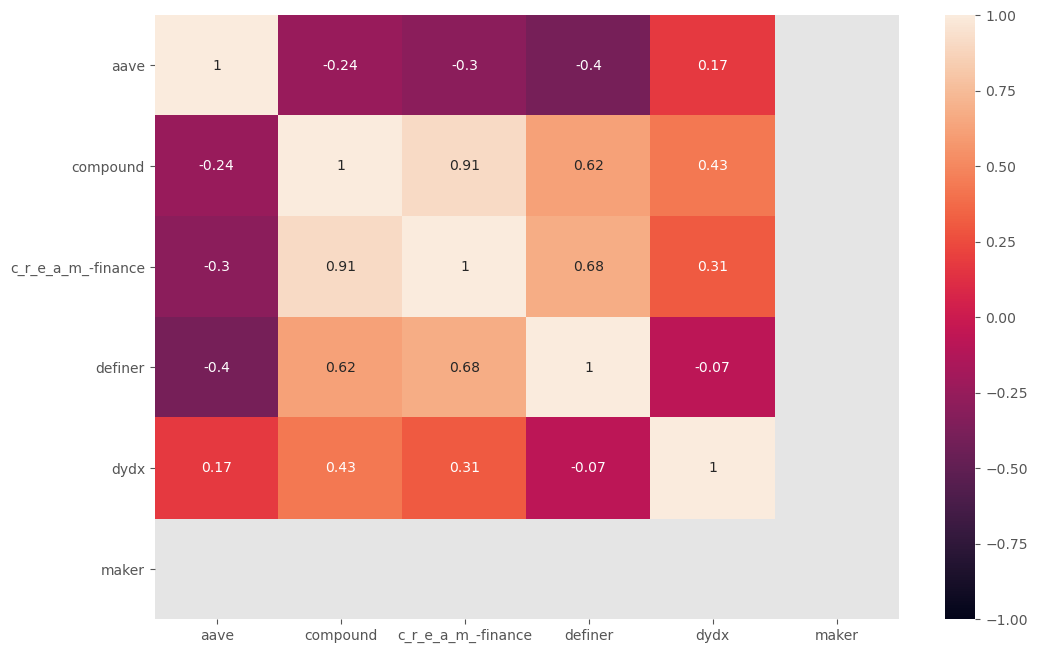

In [8]:
print("lending rates: 7 days rolling avg for last 30 days")
sns.heatmap(lend_rates_df.head(30).corr(), vmin=-1, vmax=1, annot=True)

In [9]:
lend_rates_df.std()

aave                  2.317772
compound              2.231720
c_r_e_a_m_-finance    4.960377
definer               1.445294
dydx                  5.412934
maker                 0.004832
dtype: float64

In [10]:
# start with $1, and apply daily yield each day to convert
# lend rates to automated market making (amm) returns
amm_returns = {market : [1] for market in lend_rates_df.columns}
for i, date in enumerate(lend_rates_df.index):
    if i == len(lend_rates_df.index) - 1:
        continue
    for market, returns in amm_returns.items():
        daily_yield = (1+lend_rates_df[market][i]/100)**(1/365)-1
        returns.append(returns[-1]*(1+daily_yield))   
amm_returns_df = pd.DataFrame(amm_returns, index=lend_rates_df.index)
amm_returns_df.head(10)

,aave,compound,c_r_e_a_m_-finance,definer,dydx,maker
2020-12-15,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2020-12-16,1.000251,1.000076,1.000209,1.000058,1.000083,1.0
2020-12-17,1.000507,1.000153,1.000394,1.000117,1.000173,1.0
2020-12-18,1.000759,1.000232,1.000565,1.000190,1.000275,1.0
2020-12-19,1.001026,1.000318,1.000746,1.000286,1.000386,1.0
2020-12-20,1.001280,1.000408,1.000932,1.000389,1.000505,1.0
2020-12-21,1.001527,1.000500,1.001124,1.000495,1.000635,1.0
2020-12-22,1.001766,1.000598,1.001320,1.000603,1.000774,1.0
2020-12-23,1.001997,1.000700,1.001515,1.000713,1.000924,1.0
2020-12-24,1.002215,1.000808,1.001722,1.000832,1.001096,1.0


In [11]:
amm_returns_df.tail(10)

,aave,compound,c_r_e_a_m_-finance,definer,dydx,maker
2021-06-18,1.036576,1.027091,1.060137,1.019228,1.046390,1.000030
2021-06-19,1.036643,1.027143,1.060362,1.019299,1.046436,1.000030
2021-06-20,1.036710,1.027195,1.060584,1.019369,1.046481,1.000030
2021-06-21,1.036777,1.027247,1.060806,1.019440,1.046524,1.000031
2021-06-22,1.036844,1.027298,1.060986,1.019511,1.046566,1.000031
2021-06-23,1.036910,1.027350,1.061169,1.019581,1.046609,1.000031
2021-06-24,1.036974,1.027401,1.061349,1.019651,1.046654,1.000032
2021-06-25,1.037037,1.027451,1.061532,1.019720,1.046704,1.000032
2021-06-26,1.037098,1.027500,1.061714,1.019787,1.046757,1.000032
2021-06-27,1.037158,1.027549,1.061893,1.019854,1.046814,1.000032


### Coin Data

In [12]:
data_dir = "../data/coin_data/"
exclude = {'markets.csv'}

datasets = [str(f) for f in listdir(data_dir) if isfile(join(data_dir, f)) and str(f) not in exclude]

datasets = ['binance-usd.csv', 'binancecoin.csv', 'bitcoin-cash.csv', 'bitcoin.csv', 'cardano.csv', 'cdai.csv', 'celsius-degree-token.csv', 'chainlink.csv', 'compound-ether.csv', 'compound-usd-coin.csv', 'cosmos.csv', 'dai.csv', 'decred.csv', 'dogecoin.csv', 'eos.csv', 'ethereum-classic.csv', 'ethereum.csv', 'litecoin.csv', 'monero.csv', 'neo.csv', 'ripple.csv', 'tether.csv', 'tron.csv', 'usd-coin.csv']

coin_dfs = {dataset[:-4] : pd.read_csv(data_dir+dataset, index_col=2)  for dataset in datasets}
print("coin name\tdata start")
for k, df in coin_dfs.items():
    try: 
        x_values = [datetime.strptime(d,"%Y-%m-%d %H:%M:%S.%f").date() for d in df.index]
    except ValueError:
        x_values = [datetime.strptime(d,"%Y-%m-%d %H:%M:%S").date() for d in df.index]
    df.index = x_values
    print(k, min(x_values), sep="\t")
    df.drop(columns=['timestamp'], inplace=True)

print("\n===Bitcoin===")
coin_dfs["bitcoin"].tail(10)

coin name	data start
binance-usd	2019-09-21
binancecoin	2017-09-16
bitcoin-cash	2017-08-02
bitcoin	2013-04-28
cardano	2017-10-18
cdai	2019-08-15
celsius-degree-token	2018-10-12
chainlink	2017-11-09
compound-ether	2020-03-05
compound-usd-coin	2019-09-04
cosmos	2019-02-24
dai	2019-11-19
decred	2016-02-10
dogecoin	2013-12-15
eos	2017-07-09
ethereum-classic	2016-07-24
ethereum	2015-08-07
litecoin	2013-04-28
monero	2014-05-21
neo	2016-09-09
ripple	2013-08-04
tether	2015-02-25
tron	2017-11-09
usd-coin	2018-10-05

===Bitcoin===


,price
2021-06-20,35581.642268
2021-06-21,35787.077405
2021-06-22,31711.935468
2021-06-23,32507.738707
2021-06-24,33702.617794
2021-06-25,34675.449105
2021-06-26,31943.136468
2021-06-27,32023.973902
2021-06-28,34607.293274
2021-06-29,35822.604653


In [13]:
coin_df = merge_dfs(coin_dfs, 'price')
coin_df

,binance-usd,binancecoin,bitcoin-cash,bitcoin,cardano,cdai,celsius-degree-token,chainlink,compound-ether,compound-usd-coin,...,eos,ethereum-classic,ethereum,litecoin,monero,neo,ripple,tether,tron,usd-coin
2020-03-05,1.001412,19.998017,319.168972,8758.646993,0.048898,0.020395,0.133861,4.663738,4.488143,0.021011,...,3.592350,7.934987,224.134877,60.248348,65.791586,11.738324,0.234637,1.001649,0.017633,1.001061
2020-03-06,0.998783,20.408789,326.211229,8898.758658,0.049885,0.020383,0.130013,4.673043,4.527277,0.020993,...,3.661981,8.041296,226.107906,60.947913,67.152339,11.883464,0.236318,1.000346,0.017713,1.000068
2020-03-07,0.998679,20.712547,334.152136,8977.787461,0.050383,0.020308,0.130474,4.676649,4.652791,0.021034,...,3.716605,8.089281,232.151427,61.672981,67.752176,12.038494,0.238834,1.000366,0.017917,0.999425
2020-03-08,0.999462,20.543068,333.267258,8958.891083,0.050097,0.020277,0.130049,4.594409,4.679080,0.021030,...,3.698319,8.019265,233.458768,61.362662,67.238768,11.933071,0.238399,1.000542,0.017710,0.999738
2020-03-09,1.000198,19.809827,321.125722,8775.385974,0.048735,0.020306,0.125380,4.484371,4.538846,0.021034,...,3.566434,7.698864,226.530943,59.332917,65.056200,11.553878,0.231488,0.999614,0.017136,1.000078
2020-03-10,1.000496,19.272112,313.013507,8633.043646,0.047549,0.020351,0.121534,4.413117,4.451513,0.021038,...,3.480194,7.573908,222.250264,57.781618,63.473593,11.274737,0.227711,1.000254,0.016788,1.000190
2020-03-11,1.000688,18.931173,307.048261,8529.284772,0.046670,0.020325,0.118377,4.365392,4.389136,0.021038,...,3.421219,7.462627,219.178661,56.695059,62.254509,11.075077,0.225399,1.000293,0.016543,1.000398
2020-03-12,1.000565,18.441162,299.652874,8411.695493,0.045408,0.020463,0.112294,4.245325,4.304646,0.021042,...,3.347156,7.269974,214.904813,55.019022,60.605829,10.748361,0.221859,0.999889,0.016147,1.000476
2020-03-13,1.002183,16.820210,273.436229,7855.141227,0.041529,0.020888,0.101589,3.858480,3.961310,0.021071,...,3.083438,6.657785,198.121522,50.538071,55.462880,9.845201,0.207549,0.998210,0.014824,1.001283
2020-03-14,1.003220,15.330911,248.741310,7341.851866,0.038237,0.020951,0.093754,3.535838,3.642293,0.021050,...,2.835824,6.182532,182.169291,46.897227,50.874083,8.962607,0.195272,0.999908,0.013667,1.001312


coin price in last 15 months: 7 days rolling avg


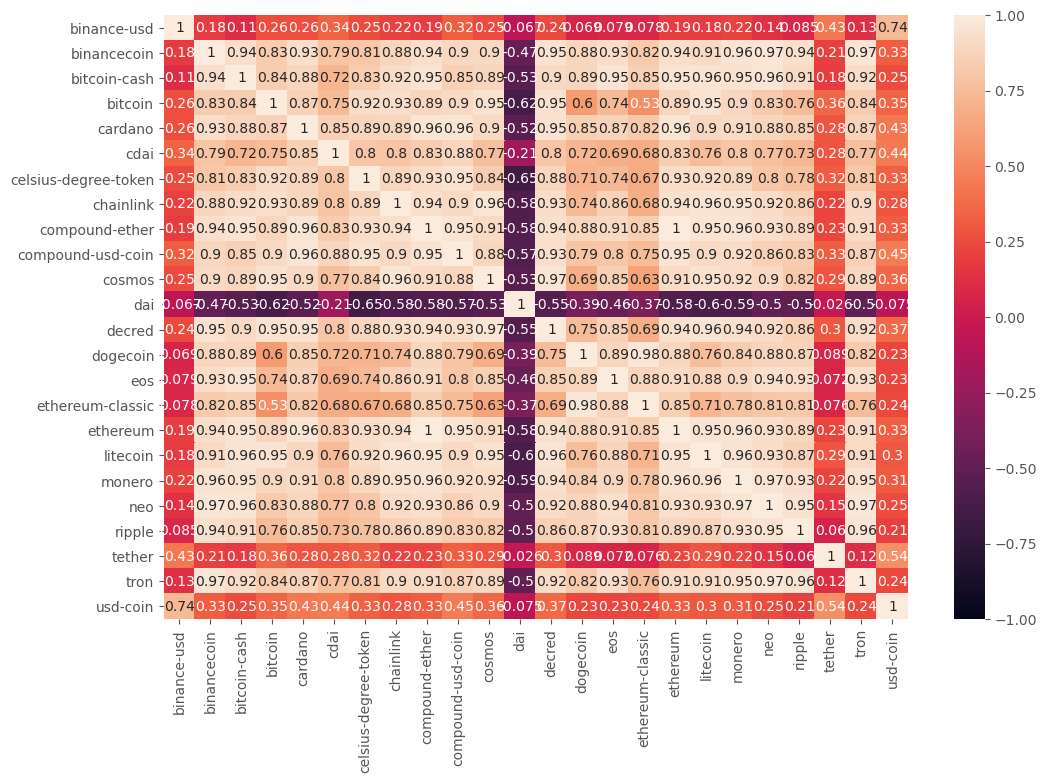

<Figure size 2500x2500 with 0 Axes>

In [14]:
print("coin price in last 15 months: 7 days rolling avg")
sns.heatmap(coin_df.corr(), vmin=-1, vmax=1, annot=True)
plt.figure(figsize=(25,25), dpi= 100)
plt.rcParams['figure.figsize'] = [25, 25]
plt.rcParams['figure.dpi'] = 100

coin price in last 15 months: 7 days rolling avg


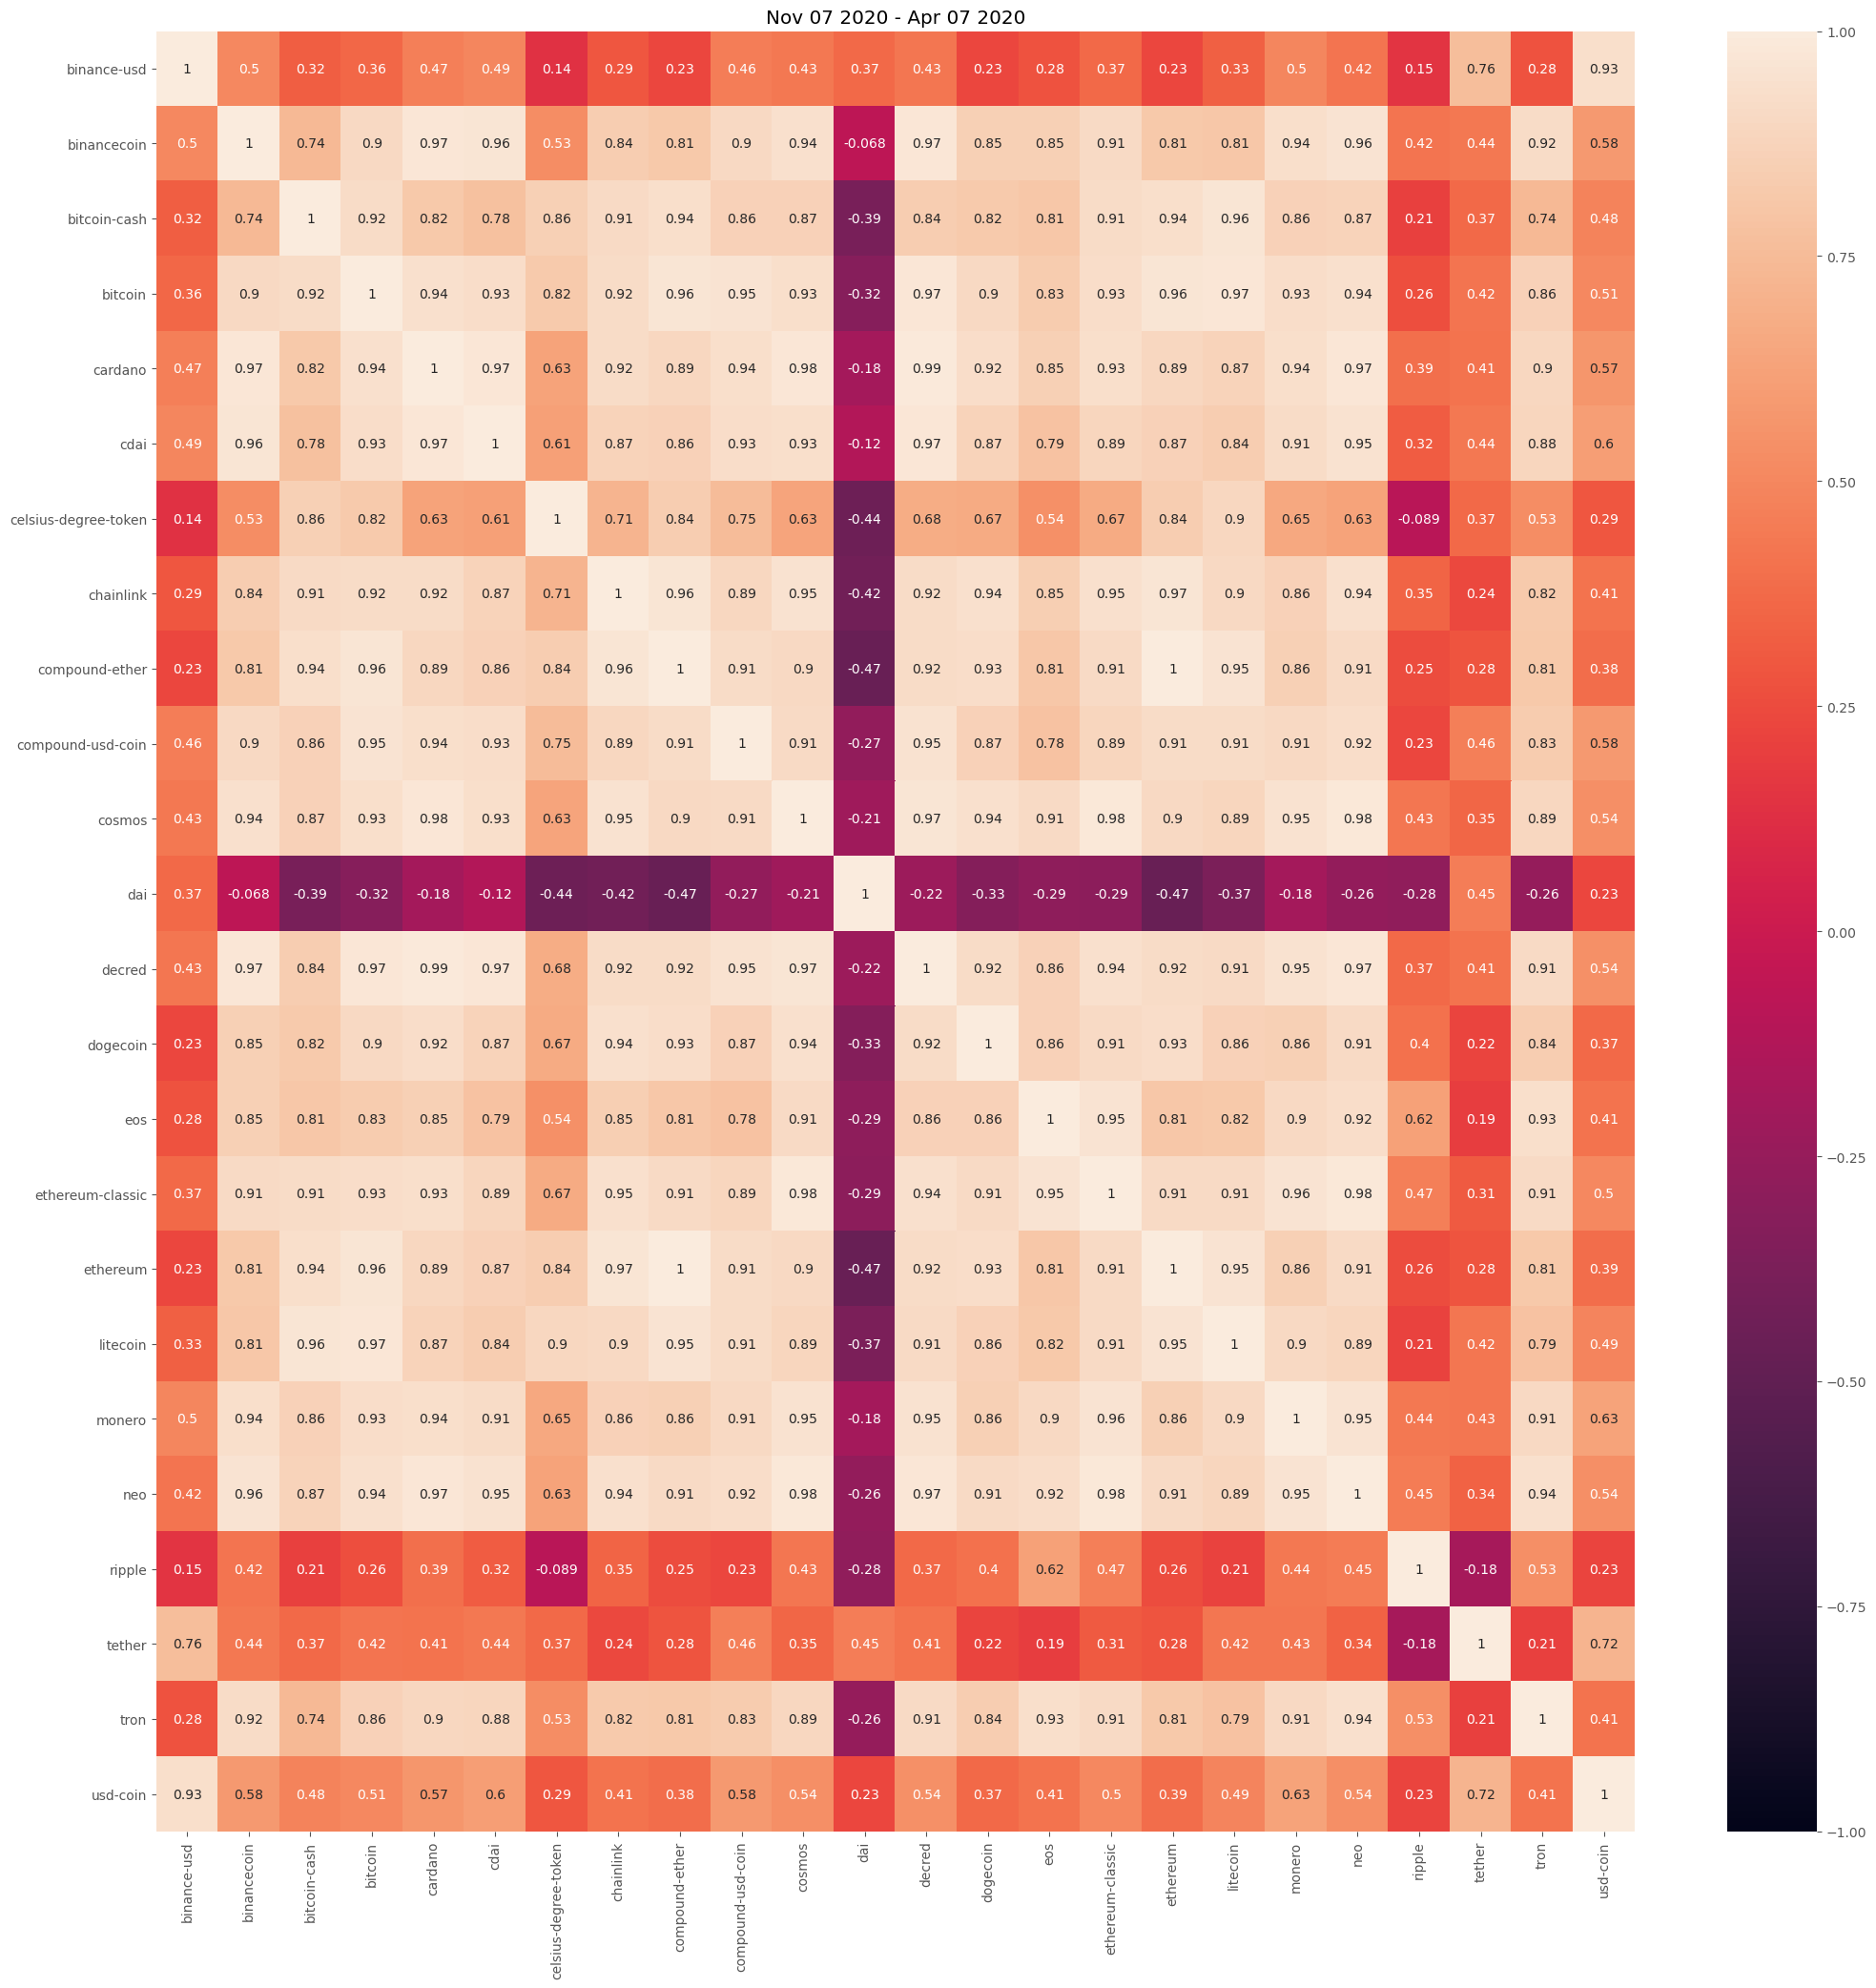

<Figure size 2500x2500 with 0 Axes>

In [15]:
print("coin price in last 15 months: 7 days rolling avg")
temp_df = coin_df[(coin_df.index > datetime.strptime('2020-11-07', '%Y-%m-%d').date()
                  ) & (coin_df.index < datetime.strptime('2021-04-07', '%Y-%m-%d').date())]
temp_df
sns.heatmap(temp_df.corr(), vmin=-1, vmax=1, annot=True)
plt.title("Nov 07 2020 - Apr 07 2020")
plt.figure(figsize=(25,25), dpi= 100)
plt.rcParams['figure.figsize'] = [25, 25]
plt.rcParams['figure.dpi'] = 100

In [16]:
# dividing by the mean because the coin prices are not on the same scale. 
# This is the relative volatility of various coins
(coin_df/coin_df.mean()).std()

binance-usd             0.001957
binancecoin             1.412199
bitcoin-cash            0.605299
bitcoin                 0.747204
cardano                 1.219446
cdai                    0.014576
celsius-degree-token    0.973324
chainlink               0.728850
compound-ether          0.978985
compound-usd-coin       0.017494
cosmos                  0.823534
dai                     0.007471
decred                  1.093315
dogecoin                1.998463
eos                     0.469134
ethereum-classic        1.392473
ethereum                0.979179
litecoin                0.730907
monero                  0.658692
neo                     0.896745
ripple                  0.818186
tether                  0.001279
tron                    0.842703
usd-coin                0.001348
dtype: float64

## Portfolio Optimization
### Low Risk: Only lending protocols

In [17]:
# split data into train and test
train_df = amm_returns_df[amm_returns_df.index < datetime.strptime('2021-04-26', '%Y-%m-%d').date()]
test_df = amm_returns_df[amm_returns_df.index >= datetime.strptime('2021-04-26', '%Y-%m-%d').date()]

train_df.head(10)

,aave,compound,c_r_e_a_m_-finance,definer,dydx,maker
2020-12-15,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2020-12-16,1.000251,1.000076,1.000209,1.000058,1.000083,1.0
2020-12-17,1.000507,1.000153,1.000394,1.000117,1.000173,1.0
2020-12-18,1.000759,1.000232,1.000565,1.000190,1.000275,1.0
2020-12-19,1.001026,1.000318,1.000746,1.000286,1.000386,1.0
2020-12-20,1.001280,1.000408,1.000932,1.000389,1.000505,1.0
2020-12-21,1.001527,1.000500,1.001124,1.000495,1.000635,1.0
2020-12-22,1.001766,1.000598,1.001320,1.000603,1.000774,1.0
2020-12-23,1.001997,1.000700,1.001515,1.000713,1.000924,1.0
2020-12-24,1.002215,1.000808,1.001722,1.000832,1.001096,1.0


In [18]:
test_df.head(10)

,aave,compound,c_r_e_a_m_-finance,definer,dydx,maker
2021-04-26,1.029226,1.022682,1.047306,1.013828,1.039061,1.000015
2021-04-27,1.029408,1.022787,1.047593,1.013938,1.039239,1.000016
2021-04-28,1.029579,1.022893,1.047871,1.014050,1.039415,1.000016
2021-04-29,1.029745,1.022998,1.048111,1.014159,1.039594,1.000016
2021-04-30,1.029908,1.023097,1.048352,1.014259,1.039781,1.000016
2021-05-01,1.030064,1.023189,1.048573,1.014351,1.039962,1.000017
2021-05-02,1.030220,1.023278,1.048796,1.014440,1.040143,1.000017
2021-05-03,1.030375,1.023366,1.049017,1.014532,1.040331,1.000017
2021-05-04,1.030526,1.023454,1.049242,1.014625,1.040521,1.000018
2021-05-05,1.030685,1.023544,1.049512,1.014724,1.040712,1.000018


In [19]:
train_df.var()

aave                  7.066921e-05
compound              4.849274e-05
c_r_e_a_m_-finance    2.260407e-04
definer               1.321901e-05
dydx                  1.666200e-04
maker                 2.235745e-11
dtype: float64

In [20]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import risk_matrix
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting
from pypfopt.base_optimizer import portfolio_performance

# expected return
mu = mean_historical_return(train_df, frequency=365)
# covariance matrix
S = risk_matrix(train_df, method='ledoit_wolf', frequency=365)
print("mean (yearly) return:")
print(mu)
print("cov matrix (of daily returns):")
print(S)
ef = EfficientFrontier(mu, S, weight_bounds=(0,1))

# plt.figure(figsize=(8,8), dpi= 100)
# plt.rcParams['figure.figsize'] = [8, 8]
# plt.rcParams['figure.dpi'] = 100

# risk_range = np.linspace(0.01, 0.90, 1000)
# plotting.plot_efficient_frontier(ef, ef_param="risk", ef_param_range=risk_range,
#                                 show_assets=False, showfig=True)
# plt.show()



mean (yearly) return:
aave                  0.083024
compound              0.064171
c_r_e_a_m_-finance    0.136503
definer               0.038686
dydx                  0.112147
maker                 0.000042
dtype: float64
cov matrix (of daily returns):
                            aave      compound  c_r_e_a_m_-finance  \
aave                4.041122e-07  8.555702e-08        3.944072e-07   
compound            8.555702e-08  6.886884e-07        9.480639e-07   
c_r_e_a_m_-finance  3.944072e-07  9.480639e-07        5.268103e-06   
definer             1.974503e-08  1.360894e-07       -5.356241e-07   
dydx               -9.225387e-08  9.650749e-07        2.813850e-06   
maker              -3.781983e-11 -3.959502e-10        1.313710e-09   

                         definer          dydx         maker  
aave                1.974503e-08 -9.225387e-08 -3.781983e-11  
compound            1.360894e-07  9.650749e-07 -3.959502e-10  
c_r_e_a_m_-finance -5.356241e-07  2.813850e-06  1.313710e-09  
def

In [21]:
weights = ef.efficient_return(target_return=0.08)
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

_ = portfolio_performance(
    weights, mu, S, verbose=True, risk_free_rate=0.02
)

OrderedDict([('aave', 0.17193), ('compound', 0.12079), ('c_r_e_a_m_-finance', 0.31426), ('definer', 0.05348), ('dydx', 0.24882), ('maker', 0.09072)])
Expected annual return: 9.5%
Annual volatility: 0.1%
Sharpe Ratio: 62.27


Now test this portfolio on the test dataset

In [22]:
# expected return
mu_test = mean_historical_return(test_df, frequency=365)
# covariance matrix
S_test = risk_matrix(test_df, method='ledoit_wolf', frequency=365)
_ = portfolio_performance(
    weights, mu_test, S_test, verbose=True, risk_free_rate=0.02
)

Expected annual return: 5.1%
Annual volatility: 0.1%
Sharpe Ratio: 41.23


## Medium Risk Portfolio
80% lending protocols and (at most) 20% BTC and ETH

In [23]:
# merge coin and amm datasets
assets_df = pd.merge(coin_df[["bitcoin", "ethereum"]], amm_returns_df, 
                     left_index=True, right_index=True, how="inner")
# split data into train and test
train_df = assets_df[assets_df.index < datetime.strptime('2021-04-26', '%Y-%m-%d').date()]
test_df = assets_df[assets_df.index >= datetime.strptime('2021-04-26', '%Y-%m-%d').date()]

train_df.head(10)

,bitcoin,ethereum,aave,compound,c_r_e_a_m_-finance,definer,dydx,maker
2020-12-15,18634.255294,568.412453,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2020-12-16,18790.804991,573.374904,1.000251,1.000076,1.000209,1.000058,1.000083,1.0
2020-12-17,19184.044374,582.241559,1.000507,1.000153,1.000394,1.000117,1.000173,1.0
2020-12-18,19833.129720,594.185988,1.000759,1.000232,1.000565,1.000190,1.000275,1.0
2020-12-19,20556.350178,609.677071,1.001026,1.000318,1.000746,1.000286,1.000386,1.0
2020-12-20,21278.744384,622.671364,1.001280,1.000408,1.000932,1.000389,1.000505,1.0
2020-12-21,21902.627812,629.698650,1.001527,1.000500,1.001124,1.000495,1.000635,1.0
2020-12-22,22414.202274,633.253669,1.001766,1.000598,1.001320,1.000603,1.000774,1.0
2020-12-23,23037.406681,639.812653,1.001997,1.000700,1.001515,1.000713,1.000924,1.0
2020-12-24,23321.758837,632.955083,1.002215,1.000808,1.001722,1.000832,1.001096,1.0


In [24]:
# expected return
mu = mean_historical_return(train_df, frequency=365)
# covariance matrix
S = risk_matrix(train_df, method='ledoit_wolf', frequency=365)
print("mean (yearly) return:")
print(mu)
print("cov matrix (of daily returns):")
print(S)
ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
# w0 is weight for btc and w1 is weight for eth. their sum should not exceed 20%
ef.add_constraint(lambda w: w[0]+w[1] <= 0.2)
ef.add_constraint(lambda w: w[-1] <= 0.05)

mean (yearly) return:
bitcoin               18.070722
ethereum              48.265719
aave                   0.083024
compound               0.064171
c_r_e_a_m_-finance     0.136503
definer                0.038686
dydx                   0.112147
maker                  0.000042
dtype: float64
cov matrix (of daily returns):
                         bitcoin      ethereum          aave      compound  \
bitcoin             1.183042e-01  9.982655e-02  5.347872e-05  3.320480e-05   
ethereum            9.982655e-02  1.606577e-01  3.147224e-05  5.352424e-05   
aave                5.347872e-05  3.147224e-05  9.128128e-04  8.561492e-08   
compound            3.320480e-05  5.352424e-05  8.561492e-08  9.130975e-04   
c_r_e_a_m_-finance -4.242750e-05 -2.401107e-04  3.946741e-07  9.487055e-07   
definer            -1.086513e-05  7.901003e-05  1.975839e-08  1.361815e-07   
dydx               -1.361829e-04 -3.361934e-04 -9.231631e-08  9.657281e-07   
maker              -2.722836e-07 -1.641244e-07 -3.78

In [25]:
weights = ef.efficient_return(target_return=.20)
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

_ = portfolio_performance(
    weights, mu, S, verbose=True, risk_free_rate=0.02
)

OrderedDict([('bitcoin', 0.0), ('ethereum', 0.00243), ('aave', 0.18988), ('compound', 0.18934), ('c_r_e_a_m_-finance', 0.1891), ('definer', 0.18984), ('dydx', 0.18938), ('maker', 0.05)])
Expected annual return: 20.0%
Annual volatility: 1.3%
Sharpe Ratio: 13.91


In [26]:
# expected return
mu_test = mean_historical_return(test_df, frequency=365)
# covariance matrix
S_test = risk_matrix(test_df, method='ledoit_wolf', frequency=365)
_ = portfolio_performance(
    weights, mu_test, S_test, verbose=True, risk_free_rate=0.02
)

Expected annual return: 4.4%
Annual volatility: 1.8%
Sharpe Ratio: 1.33


## High Risk Portfolio
We add all top tokens and lending protocols and let the model optimize.

In [27]:
# merge coin and amm datasets
assets_df = pd.merge(coin_df[["bitcoin", "ethereum", "cardano", "monero", "litecoin", "dogecoin",
                             "chainlink", "ethereum-classic", "tether", "ripple"]], amm_returns_df, 
                     left_index=True, right_index=True, how="inner")
# split data into train and test
train_df = assets_df[assets_df.index < datetime.strptime('2021-04-26', '%Y-%m-%d').date()]
test_df = assets_df[assets_df.index >= datetime.strptime('2021-04-26', '%Y-%m-%d').date()]

train_df.head(10)

,bitcoin,ethereum,cardano,monero,litecoin,dogecoin,chainlink,ethereum-classic,tether,ripple,aave,compound,c_r_e_a_m_-finance,definer,dydx,maker
2020-12-15,18634.255294,568.412453,0.146753,142.218269,77.502673,0.003170,12.339228,5.952574,0.999590,0.540264,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2020-12-16,18790.804991,573.374904,0.148578,144.381033,78.152673,0.003175,12.419870,5.993455,0.999819,0.527241,1.000251,1.000076,1.000209,1.000058,1.000083,1.0
2020-12-17,19184.044374,582.241559,0.151347,148.052088,80.321417,0.003213,12.532690,6.043654,0.999526,0.524907,1.000507,1.000153,1.000394,1.000117,1.000173,1.0
2020-12-18,19833.129720,594.185988,0.154373,151.840792,84.155829,0.003300,12.751707,6.125209,0.999017,0.525089,1.000759,1.000232,1.000565,1.000190,1.000275,1.0
2020-12-19,20556.350178,609.677071,0.157983,153.705603,89.429753,0.003409,13.009846,6.207041,0.998862,0.529858,1.001026,1.000318,1.000746,1.000286,1.000386,1.0
2020-12-20,21278.744384,622.671364,0.160911,154.864143,95.707190,0.003518,13.192852,6.271811,0.998791,0.540443,1.001280,1.000408,1.000932,1.000389,1.000505,1.0
2020-12-21,21902.627812,629.698650,0.162082,154.956077,100.403085,0.003711,13.213686,6.326080,0.999313,0.547493,1.001527,1.000500,1.001124,1.000495,1.000635,1.0
2020-12-22,22414.202274,633.253669,0.161509,154.060978,103.631795,0.003936,13.147604,6.341893,0.999661,0.550290,1.001766,1.000598,1.001320,1.000603,1.000774,1.0
2020-12-23,23037.406681,639.812653,0.161931,154.857370,108.314896,0.004124,13.163906,6.353687,0.999973,0.547762,1.001997,1.000700,1.001515,1.000713,1.000924,1.0
2020-12-24,23321.758837,632.955083,0.157759,153.837902,109.763302,0.004182,12.846762,6.167523,1.000754,0.503947,1.002215,1.000808,1.001722,1.000832,1.001096,1.0


In [28]:
# expected return
mu = mean_historical_return(train_df, frequency=365)
# covariance matrix
S = risk_matrix(train_df, method='ledoit_wolf', frequency=365)
print("mean (yearly) return:")
print(mu)
print("cov matrix (of daily returns):")
print(S)
ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
# w0 is weight for btc and w1 is weight for eth. their sum should not exceed 20%
ef.add_constraint(lambda w: w[0]+w[1] <= 0.2)
ef.add_constraint(lambda w: w[-1] <= 0.05)

mean (yearly) return:
bitcoin                   18.070722
ethereum                  48.265719
cardano                  343.198378
monero                    12.976375
litecoin                  26.258711
dogecoin              340898.707634
chainlink                 18.760740
ethereum-classic         119.973361
tether                     0.000892
ripple                     9.522836
aave                       0.083024
compound                   0.064171
c_r_e_a_m_-finance         0.136503
definer                    0.038686
dydx                       0.112147
maker                      0.000042
dtype: float64
cov matrix (of daily returns):
                         bitcoin      ethereum       cardano        monero  \
bitcoin             1.398056e-01  9.225795e-02  9.810708e-02  4.457005e-02   
ethereum            9.225795e-02  1.789480e-01  9.610155e-02  2.621456e-02   
cardano             9.810708e-02  9.610155e-02  3.296515e-01  2.579487e-02   
monero              4.457005e-02  2.621456e-

In [29]:
weights = ef.efficient_return(target_return=.20)
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

_ = portfolio_performance(
    weights, mu, S, verbose=True, risk_free_rate=0.02
)

OrderedDict([('bitcoin', 0.01664), ('ethereum', 0.0088), ('cardano', 0.00216), ('monero', 0.01786), ('litecoin', 0.0), ('dogecoin', 0.0), ('chainlink', 0.00926), ('ethereum-classic', 0.0), ('tether', 0.14894), ('ripple', 0.00017), ('aave', 0.14916), ('compound', 0.14916), ('c_r_e_a_m_-finance', 0.14922), ('definer', 0.14922), ('dydx', 0.14941), ('maker', 0.05)])
Expected annual return: 194.0%
Annual volatility: 6.7%
Sharpe Ratio: 28.56


In [30]:
# expected return
mu_test = mean_historical_return(test_df, frequency=365)
# covariance matrix
S_test = risk_matrix(test_df, method='ledoit_wolf', frequency=365)
_ = portfolio_performance(
    weights, mu_test, S_test, verbose=True, risk_free_rate=0.02
)

Expected annual return: -0.9%
Annual volatility: 5.4%
Sharpe Ratio: -0.54
